In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [2]:
from torchvision.transforms import v2
torch.manual_seed(19)

transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(60),
    v2.ToDtype(torch.float32)
])


class NCaltech101ImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.transform = transform
        self.stage = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((101,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
training_data = NCaltech101ImageDataset("./Datasety/Ncaltech101_EST_trilinear_corr", transform=transforms)

torch.float32 torch.float64


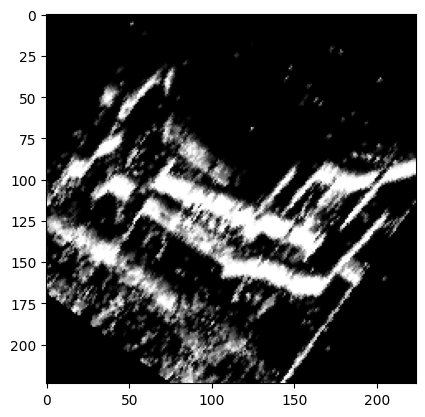

tensor(1.)


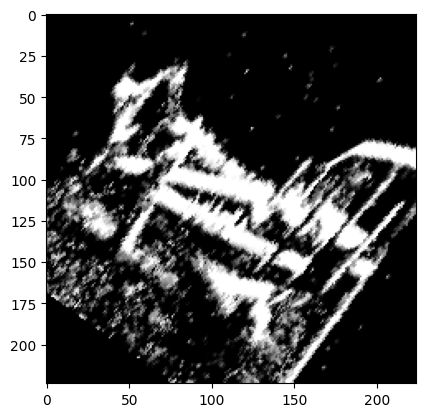

tensor(1.)


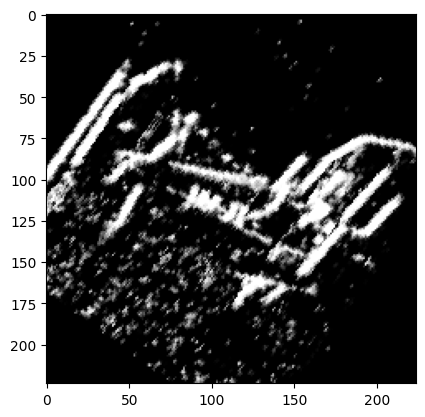

tensor(1.)


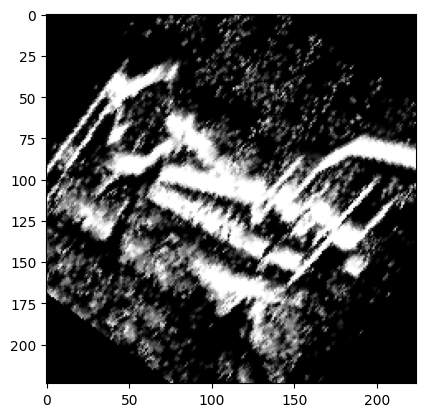

tensor(1.)


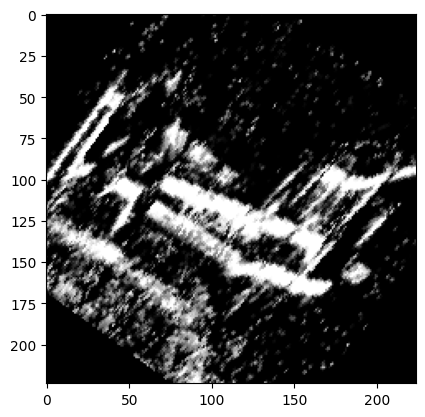

tensor(1.)


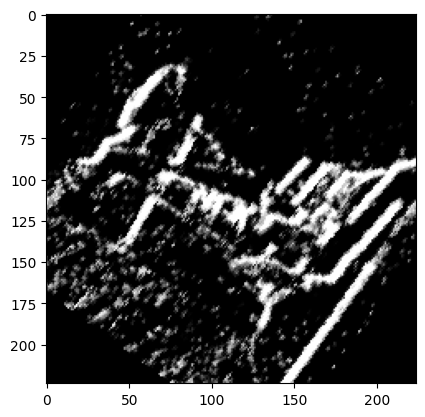

tensor(1.)


In [4]:
pic, label = training_data[100]
print(pic.dtype, label.dtype)
noBins = 3
for i in range(2*noBins):
    pic2 = pic[i,...]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(torch.max(pic2))

In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(training_data, [0.8, 0.2])

In [6]:
from torch.utils.data import WeightedRandomSampler
train_dataset.dataset.set_stage(1)
class_sample_count = np.zeros(101)
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    class_sample_count[np.argmax(label)] += 1

weight = 1. / class_sample_count
samples_weight = np.array([weight[int(np.argmax(train_dataset[t][1]))] for t in range(len(train_dataset))])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [8]:
import torch.optim.lr_scheduler as lr_scheduler
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0,max_val=1,inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = self.relu(out)
        else:
            out = self.relu(out)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x,min_val=0, max_val=1,inplace=False)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x# F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.0025, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.float32)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                regularization_loss = 0
                for param in self.parameters():
                    regularization_loss += torch.sum(torch.abs(param))

                loss = criterion(outputs, labels) + 0.00001*regularization_loss
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.float32)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    regularization_loss = 0
                    for param in self.parameters():
                        regularization_loss += torch.sum(torch.abs(param))
                    loss = criterion(outputs, labels) + 0.00001*regularization_loss
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCaltech101_ReLU_ReLU1_ReLUmaxpool_EST__FC2_corrected_trilinear_mixed_L1_L2_Vol2.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
#         super(ResidualBlock, self).__init__()
#         if(downsample is not None):
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU(inplace=False),
#                             nn.MaxPool2d(kernel_size=2, stride=2)
#                             )  # Changed inplace to False
#         else:
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU( inplace=False)
#                             )
#         self.conv2 = nn.Sequential(
#                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#                         nn.BatchNorm2d(out_channels),
#                         nn.ReLU( inplace=False))  # Changed inplace to False
#         self.downsample = downsample
#         self.relu = nn.ReLU( inplace=False)  # Changed inplace to False
#         self.out_channels = out_channels
#         self.end_maxpool = end_maxpool

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out = out + residual
#         if self.end_maxpool:
#             out = F.relu(out, inplace=False)
#         else:
#             out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes = 2, in_channels = 5):
#         super(ResNet, self).__init__()
#         self.inplanes = 64
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
#                         nn.BatchNorm2d(64),
#                         nn.ReLU(inplace=False))
#         self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
#         self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
#         self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
#         self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
#         self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
#         self.avgpool = nn.MaxPool2d(7, stride=1)
#         self.fc = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, num_classes)
#         self.dropout = nn.Dropout(0.2)

#     def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
#         downsample = None
#         if stride != 1 or self.inplanes != planes:

#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
#                 nn.BatchNorm2d(planes),
#                 nn.ReLU(inplace=False),
#                 nn.MaxPool2d(kernel_size=2, stride=2)
#             )
#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes
#         for i in range(1, blocks):
#             if i == blocks-1 and end_maxpool:
#                 layers.append(block(self.inplanes, planes, end_maxpool = True))
#             else:
#                 layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = F.hardtanh(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x# F.hardtanh(x)
    
#     def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
#         best_accuracy = 0.0
#         total_step = len(train_loader)
#         # Loss and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#         for epoch in range(num_epochs):
#             # self.train()
#             correct = 0
#             total = 0
#             running_loss = 0.0
#             train_loader.dataset.dataset.set_stage(0)
#             for i, (images, labels) in enumerate(tqdm(train_loader)):
#                 # Move tensors to the configured device
#                 images = images.float().to("cuda")
#                 labels = labels.type(torch.FloatTensor)
#                 labels = labels.to("cuda")


#                 optimizer.zero_grad()

#                 # Forward pass
#                 outputs = self.forward(images)
#                 loss = criterion(outputs, labels)
#                 # Backward and optimize
#                 loss.backward()
                
#                 optimizer.step()

#                 # accuracy
#                 _, predicted = torch.max(outputs.data, 1)
#                 correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                 total += labels.size(0)
#                 running_loss += loss.item()
#                 del images, labels, outputs

#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
#                             .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#             # Validation
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 val_loss = 0.0
#                 valid_loader.dataset.dataset.set_stage(1)
#                 for images, labels in valid_loader:
#                     images = images.float().to("cuda")
#                     labels = labels.type(torch.FloatTensor)
#                     labels = labels.to("cuda")
#                     outputs = self.forward(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item()
#                     del images, labels, outputs
#                 if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
#                     torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

#                 print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))

In [9]:
model_resnet = ResNet(ResidualBlock, [5, 6, 6, 4], in_channels = 6, num_classes=101).to("cuda")

In [10]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300, save_best = True, save_thr = 0.38)

100%|██████████| 109/109 [01:01<00:00,  1.77it/s]


Epoch [1/300], Step [109/109], Loss: 6.2089, Accuracy: 0.0111
Accuracy of the network: 1.321079839172889 Loss: 5.173425223610618%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [2/300], Step [109/109], Loss: 4.9345, Accuracy: 0.0161
Accuracy of the network: 4.192992533026996 Loss: 4.8123210040005775%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [3/300], Step [109/109], Loss: 4.7378, Accuracy: 0.0227
Accuracy of the network: 1.7805858701895463 Loss: 4.698469777540727%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [4/300], Step [109/109], Loss: 4.6589, Accuracy: 0.0290
Accuracy of the network: 4.422745548535325 Loss: 4.741715387864546%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [5/300], Step [109/109], Loss: 4.6461, Accuracy: 0.0301
Accuracy of the network: 1.6082711085583 Loss: 4.688931153037331%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [6/300], Step [109/109], Loss: 4.5989, Accuracy: 0.0317
Accuracy of the network: 3.2165422171166 Loss: 4.643278243324973%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [7/300], Step [109/109], Loss: 4.5747, Accuracy: 0.0425
Accuracy of the network: 7.696726019529006 Loss: 4.501349674571644%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [8/300], Step [109/109], Loss: 4.5097, Accuracy: 0.0416
Accuracy of the network: 6.835152211372774 Loss: 4.486770612543279%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [9/300], Step [109/109], Loss: 4.4740, Accuracy: 0.0515
Accuracy of the network: 11.717403790924756 Loss: 4.433734078840776%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [10/300], Step [109/109], Loss: 4.4284, Accuracy: 0.0571
Accuracy of the network: 6.031016657093624 Loss: 4.3565789829600945%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [11/300], Step [109/109], Loss: 4.4236, Accuracy: 0.0538
Accuracy of the network: 4.652498564043653 Loss: 4.4330095551230695%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [12/300], Step [109/109], Loss: 4.3889, Accuracy: 0.0550
Accuracy of the network: 8.61573808156232 Loss: 4.349170511419123%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [13/300], Step [109/109], Loss: 4.3360, Accuracy: 0.0673
Accuracy of the network: 10.626076967260195 Loss: 4.281346481496637%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [14/300], Step [109/109], Loss: 4.3022, Accuracy: 0.0811
Accuracy of the network: 10.74095347501436 Loss: 4.104144950346513%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [15/300], Step [109/109], Loss: 4.1938, Accuracy: 0.0896
Accuracy of the network: 8.500861573808157 Loss: 4.020316414399581%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [16/300], Step [109/109], Loss: 4.0783, Accuracy: 0.1088
Accuracy of the network: 16.36990235496841 Loss: 3.8816448775204746%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [17/300], Step [109/109], Loss: 4.0214, Accuracy: 0.1250
Accuracy of the network: 15.106260769672602 Loss: 3.8807635003870184%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [18/300], Step [109/109], Loss: 3.9598, Accuracy: 0.1253
Accuracy of the network: 12.34922458357266 Loss: 3.9917359612204812%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [19/300], Step [109/109], Loss: 3.9449, Accuracy: 0.1343
Accuracy of the network: 17.288914417001724 Loss: 3.7500400066375734%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [20/300], Step [109/109], Loss: 3.9267, Accuracy: 0.1392
Accuracy of the network: 18.609994256174613 Loss: 3.78978704105724%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [21/300], Step [109/109], Loss: 3.9085, Accuracy: 0.1342
Accuracy of the network: 17.805858701895463 Loss: 3.8529730319976805%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [22/300], Step [109/109], Loss: 3.8562, Accuracy: 0.1468
Accuracy of the network: 16.94428489373923 Loss: 3.896897315979004%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [23/300], Step [109/109], Loss: 3.8321, Accuracy: 0.1501
Accuracy of the network: 22.05628948879954 Loss: 3.708385614915328%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [24/300], Step [109/109], Loss: 3.8046, Accuracy: 0.1593
Accuracy of the network: 15.680643308443424 Loss: 3.7044239911166104%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [25/300], Step [109/109], Loss: 3.7974, Accuracy: 0.1520
Accuracy of the network: 21.883974727168294 Loss: 3.699628162384033%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [26/300], Step [109/109], Loss: 3.7862, Accuracy: 0.1603
Accuracy of the network: 21.19471568064331 Loss: 3.6229001738808373%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [27/300], Step [109/109], Loss: 3.7780, Accuracy: 0.1593
Accuracy of the network: 18.380241240666283 Loss: 3.746458573774858%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [28/300], Step [109/109], Loss: 3.7516, Accuracy: 0.1600
Accuracy of the network: 15.680643308443424 Loss: 3.7969803333282472%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [29/300], Step [109/109], Loss: 3.7334, Accuracy: 0.1623
Accuracy of the network: 16.94428489373923 Loss: 3.6579665834253485%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [30/300], Step [109/109], Loss: 3.6806, Accuracy: 0.1676
Accuracy of the network: 17.116599655370475 Loss: 3.6773539543151856%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [31/300], Step [109/109], Loss: 3.6365, Accuracy: 0.1857
Accuracy of the network: 20.562894887995405 Loss: 3.631459938396107%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [32/300], Step [109/109], Loss: 3.6349, Accuracy: 0.1838
Accuracy of the network: 17.346352670878805 Loss: 3.772718351537531%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [33/300], Step [109/109], Loss: 3.6411, Accuracy: 0.1847
Accuracy of the network: 20.50545663411832 Loss: 3.6280014384876598%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [34/300], Step [109/109], Loss: 3.6041, Accuracy: 0.2001
Accuracy of the network: 21.137277426766225 Loss: 3.4880675662647596%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [35/300], Step [109/109], Loss: 3.5501, Accuracy: 0.2054
Accuracy of the network: 22.688110281447443 Loss: 3.538222599029541%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [36/300], Step [109/109], Loss: 3.5232, Accuracy: 0.2176
Accuracy of the network: 26.07696726019529 Loss: 3.4452342163432728%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [37/300], Step [109/109], Loss: 3.4527, Accuracy: 0.2280
Accuracy of the network: 26.536473291211948 Loss: 3.439471379193393%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [38/300], Step [109/109], Loss: 3.4526, Accuracy: 0.2272
Accuracy of the network: 26.708788052843193 Loss: 3.4093764651905407%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [39/300], Step [109/109], Loss: 3.4108, Accuracy: 0.2344
Accuracy of the network: 29.408385985066055 Loss: 3.289558419314298%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [40/300], Step [109/109], Loss: 3.3558, Accuracy: 0.2473
Accuracy of the network: 20.333141872487076 Loss: 3.4708309823816474%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [41/300], Step [109/109], Loss: 3.3371, Accuracy: 0.2468
Accuracy of the network: 28.83400344629523 Loss: 3.270597704974088%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [42/300], Step [109/109], Loss: 3.3278, Accuracy: 0.2443
Accuracy of the network: 25.847214244686963 Loss: 3.3079490314830435%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [43/300], Step [109/109], Loss: 3.2940, Accuracy: 0.2572
Accuracy of the network: 25.157955198161975 Loss: 3.2624341531233356%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [44/300], Step [109/109], Loss: 3.2619, Accuracy: 0.2662
Accuracy of the network: 25.04307869040781 Loss: 3.329383520646529%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [45/300], Step [109/109], Loss: 3.2730, Accuracy: 0.2577
Accuracy of the network: 30.61458931648478 Loss: 3.1908353025263008%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [46/300], Step [109/109], Loss: 3.2280, Accuracy: 0.2659
Accuracy of the network: 33.71625502584721 Loss: 3.152553367614746%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [47/300], Step [109/109], Loss: 3.1701, Accuracy: 0.2826
Accuracy of the network: 23.434807581849512 Loss: 3.3932344870133835%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [48/300], Step [109/109], Loss: 3.1392, Accuracy: 0.2860
Accuracy of the network: 29.465824238943135 Loss: 3.178915344585072%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [49/300], Step [109/109], Loss: 3.1398, Accuracy: 0.2877
Accuracy of the network: 30.32739804709937 Loss: 3.170931066166271%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [50/300], Step [109/109], Loss: 3.1139, Accuracy: 0.3021
Accuracy of the network: 28.087306145893166 Loss: 3.156636918674816%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [51/300], Step [109/109], Loss: 3.0946, Accuracy: 0.3031
Accuracy of the network: 30.38483630097645 Loss: 3.141377327658913%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [52/300], Step [109/109], Loss: 3.0407, Accuracy: 0.3127
Accuracy of the network: 29.81045376220563 Loss: 3.1779610243710605%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [53/300], Step [109/109], Loss: 3.0253, Accuracy: 0.3133
Accuracy of the network: 30.844342331993108 Loss: 3.106596105748957%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [54/300], Step [109/109], Loss: 3.0324, Accuracy: 0.3124
Accuracy of the network: 30.844342331993108 Loss: 3.0864890228618274%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [55/300], Step [109/109], Loss: 2.9987, Accuracy: 0.3249
Accuracy of the network: 28.02986789201608 Loss: 3.1574937213550913%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [56/300], Step [109/109], Loss: 2.9891, Accuracy: 0.3182
Accuracy of the network: 35.03733486502011 Loss: 2.9587594682520084%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [57/300], Step [109/109], Loss: 2.9609, Accuracy: 0.3321
Accuracy of the network: 32.85468121769098 Loss: 3.0128868536515667%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [58/300], Step [109/109], Loss: 2.9593, Accuracy: 0.3192
Accuracy of the network: 30.844342331993108 Loss: 3.038400394266302%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [59/300], Step [109/109], Loss: 2.9248, Accuracy: 0.3358
Accuracy of the network: 33.37162550258472 Loss: 3.0137322989377107%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [60/300], Step [109/109], Loss: 2.9052, Accuracy: 0.3423
Accuracy of the network: 34.75014359563469 Loss: 2.966957460750233%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [61/300], Step [109/109], Loss: 2.9149, Accuracy: 0.3390
Accuracy of the network: 33.4290637564618 Loss: 2.9388103225014426%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [62/300], Step [109/109], Loss: 2.9221, Accuracy: 0.3431
Accuracy of the network: 34.4055140723722 Loss: 2.964746518568559%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [63/300], Step [109/109], Loss: 2.8965, Accuracy: 0.3407
Accuracy of the network: 34.46295232624928 Loss: 2.955732315236872%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [64/300], Step [109/109], Loss: 2.8944, Accuracy: 0.3360
Accuracy of the network: 32.73980470993682 Loss: 2.995863069187511%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [65/300], Step [109/109], Loss: 2.8245, Accuracy: 0.3606
Accuracy of the network: 35.841470419299256 Loss: 2.9372580441561613%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [66/300], Step [109/109], Loss: 2.8327, Accuracy: 0.3526
Accuracy of the network: 34.4055140723722 Loss: 2.9505027640949595%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [67/300], Step [109/109], Loss: 2.8622, Accuracy: 0.3529
Accuracy of the network: 36.645605973578405 Loss: 2.8928002400831745%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [68/300], Step [109/109], Loss: 2.8160, Accuracy: 0.3608
Accuracy of the network: 35.43940264215968 Loss: 2.901002142646096%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [69/300], Step [109/109], Loss: 2.7848, Accuracy: 0.3685
Accuracy of the network: 38.541068351522114 Loss: 2.7887067924846303%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [70/300], Step [109/109], Loss: 2.7684, Accuracy: 0.3749
Accuracy of the network: 35.43940264215968 Loss: 2.8876974019137296%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [71/300], Step [109/109], Loss: 2.7808, Accuracy: 0.3673
Accuracy of the network: 39.115450890292934 Loss: 2.8003395687450063%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [72/300], Step [109/109], Loss: 2.7490, Accuracy: 0.3741
Accuracy of the network: 32.39517518667432 Loss: 2.855335556377064%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [73/300], Step [109/109], Loss: 2.7358, Accuracy: 0.3784
Accuracy of the network: 37.277426766226306 Loss: 2.817193534157493%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [74/300], Step [109/109], Loss: 2.7005, Accuracy: 0.3835
Accuracy of the network: 35.3819643882826 Loss: 2.8711196249181574%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [75/300], Step [109/109], Loss: 2.6922, Accuracy: 0.3875
Accuracy of the network: 36.645605973578405 Loss: 2.844061595743353%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [76/300], Step [109/109], Loss: 2.6893, Accuracy: 0.3776
Accuracy of the network: 37.966685812751294 Loss: 2.7718229683962736%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [77/300], Step [109/109], Loss: 2.6668, Accuracy: 0.3888
Accuracy of the network: 39.34520390580126 Loss: 2.7688875371759587%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [78/300], Step [109/109], Loss: 2.6691, Accuracy: 0.3944
Accuracy of the network: 36.071223434807585 Loss: 2.8042573365298185%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [79/300], Step [109/109], Loss: 2.6473, Accuracy: 0.3967
Accuracy of the network: 40.20677771395749 Loss: 2.7043688427318227%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [80/300], Step [109/109], Loss: 2.6265, Accuracy: 0.4008
Accuracy of the network: 39.172889144170014 Loss: 2.7198286056518555%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [81/300], Step [109/109], Loss: 2.6080, Accuracy: 0.4086
Accuracy of the network: 41.12578977599081 Loss: 2.6632551366632633%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [82/300], Step [109/109], Loss: 2.6312, Accuracy: 0.4008
Accuracy of the network: 40.26421596783458 Loss: 2.6907488042658025%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [83/300], Step [109/109], Loss: 2.5976, Accuracy: 0.4069
Accuracy of the network: 39.91958644457208 Loss: 2.6843755852092395%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [84/300], Step [109/109], Loss: 2.6111, Accuracy: 0.4031
Accuracy of the network: 38.19643882825962 Loss: 2.729856369712136%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [85/300], Step [109/109], Loss: 2.5396, Accuracy: 0.4234
Accuracy of the network: 39.74727168294084 Loss: 2.650822548432784%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [86/300], Step [109/109], Loss: 2.5496, Accuracy: 0.4311
Accuracy of the network: 42.04480183802412 Loss: 2.626566050269387%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [87/300], Step [109/109], Loss: 2.5249, Accuracy: 0.4264
Accuracy of the network: 39.97702469844917 Loss: 2.6558887351642957%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [88/300], Step [109/109], Loss: 2.5104, Accuracy: 0.4282
Accuracy of the network: 38.71338311315336 Loss: 2.6899532188068735%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [89/300], Step [109/109], Loss: 2.5032, Accuracy: 0.4374
Accuracy of the network: 39.97702469844917 Loss: 2.6268667957999488%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [90/300], Step [109/109], Loss: 2.4936, Accuracy: 0.4307
Accuracy of the network: 41.58529580700747 Loss: 2.592312700098211%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [91/300], Step [109/109], Loss: 2.4781, Accuracy: 0.4336
Accuracy of the network: 44.34233199310741 Loss: 2.5389100291512228%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [92/300], Step [109/109], Loss: 2.4874, Accuracy: 0.4379
Accuracy of the network: 39.172889144170014 Loss: 2.7152955662120473%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [93/300], Step [109/109], Loss: 2.4284, Accuracy: 0.4559
Accuracy of the network: 41.75761056863871 Loss: 2.6118965365669946%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [94/300], Step [109/109], Loss: 2.4460, Accuracy: 0.4466
Accuracy of the network: 41.58529580700747 Loss: 2.5663249882784758%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [95/300], Step [109/109], Loss: 2.4152, Accuracy: 0.4618
Accuracy of the network: 43.36588167719702 Loss: 2.552466741475192%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [96/300], Step [109/109], Loss: 2.4272, Accuracy: 0.4545
Accuracy of the network: 40.4939689833429 Loss: 2.6011336304924706%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [97/300], Step [109/109], Loss: 2.3714, Accuracy: 0.4630
Accuracy of the network: 44.57208500861574 Loss: 2.493997411294417%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [98/300], Step [109/109], Loss: 2.3654, Accuracy: 0.4617
Accuracy of the network: 44.39977024698449 Loss: 2.499559918316928%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [99/300], Step [109/109], Loss: 2.3702, Accuracy: 0.4666
Accuracy of the network: 43.25100516944285 Loss: 2.52908850366419%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [100/300], Step [109/109], Loss: 2.3243, Accuracy: 0.4839
Accuracy of the network: 42.96381390005744 Loss: 2.5533924081108785%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [101/300], Step [109/109], Loss: 2.3234, Accuracy: 0.4630
Accuracy of the network: 44.055140723722 Loss: 2.496544471654025%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [102/300], Step [109/109], Loss: 2.2899, Accuracy: 0.4826
Accuracy of the network: 41.92992533026996 Loss: 2.513284353776412%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [103/300], Step [109/109], Loss: 2.3231, Accuracy: 0.4679
Accuracy of the network: 43.882825962090756 Loss: 2.511358308792114%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [104/300], Step [109/109], Loss: 2.2610, Accuracy: 0.4927
Accuracy of the network: 42.84893739230328 Loss: 2.4818881728432394%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [105/300], Step [109/109], Loss: 2.2978, Accuracy: 0.4801
Accuracy of the network: 47.32912119471568 Loss: 2.3837666338140315%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [106/300], Step [109/109], Loss: 2.2576, Accuracy: 0.4934
Accuracy of the network: 45.089029293509476 Loss: 2.430111698670821%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [107/300], Step [109/109], Loss: 2.2400, Accuracy: 0.4978
Accuracy of the network: 44.974152785755315 Loss: 2.452349667115645%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [108/300], Step [109/109], Loss: 2.2566, Accuracy: 0.4901
Accuracy of the network: 44.227455485353246 Loss: 2.4207291342995383%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [109/300], Step [109/109], Loss: 2.2212, Accuracy: 0.4951
Accuracy of the network: 44.39977024698449 Loss: 2.419942114569924%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [110/300], Step [109/109], Loss: 2.2253, Accuracy: 0.4945
Accuracy of the network: 43.48075818495118 Loss: 2.4522766330025414%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [111/300], Step [109/109], Loss: 2.2179, Accuracy: 0.5016
Accuracy of the network: 46.984491671453185 Loss: 2.3720726641741665%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [112/300], Step [109/109], Loss: 2.1938, Accuracy: 0.5055
Accuracy of the network: 46.639862148190694 Loss: 2.363676077669317%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [113/300], Step [109/109], Loss: 2.1760, Accuracy: 0.5116
Accuracy of the network: 44.85927627800115 Loss: 2.41326198794625%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [114/300], Step [109/109], Loss: 2.1376, Accuracy: 0.5214
Accuracy of the network: 44.91671453187823 Loss: 2.4036299553784457%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [115/300], Step [109/109], Loss: 2.1303, Accuracy: 0.5175
Accuracy of the network: 46.352670878805284 Loss: 2.343358063697815%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [116/300], Step [109/109], Loss: 2.1452, Accuracy: 0.5187
Accuracy of the network: 47.61631246410109 Loss: 2.3512330293655395%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [117/300], Step [109/109], Loss: 2.1348, Accuracy: 0.5129
Accuracy of the network: 46.352670878805284 Loss: 2.343890079584989%


100%|██████████| 109/109 [01:34<00:00,  1.16it/s]


Epoch [118/300], Step [109/109], Loss: 2.1518, Accuracy: 0.5126
Accuracy of the network: 47.443997702469844 Loss: 2.3855739268389615%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [119/300], Step [109/109], Loss: 2.0927, Accuracy: 0.5261
Accuracy of the network: 45.835726593911545 Loss: 2.3857924071225254%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [120/300], Step [109/109], Loss: 2.0908, Accuracy: 0.5247
Accuracy of the network: 45.318782309017806 Loss: 2.367266377535733%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [121/300], Step [109/109], Loss: 2.1044, Accuracy: 0.5222
Accuracy of the network: 42.04480183802412 Loss: 2.4618752999739213%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [122/300], Step [109/109], Loss: 2.0541, Accuracy: 0.5344
Accuracy of the network: 48.01838024124066 Loss: 2.2993931033394555%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [123/300], Step [109/109], Loss: 2.0767, Accuracy: 0.5317
Accuracy of the network: 45.376220562894886 Loss: 2.383617132360285%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [124/300], Step [109/109], Loss: 2.0533, Accuracy: 0.5327
Accuracy of the network: 47.78862722573234 Loss: 2.283465931632302%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [125/300], Step [109/109], Loss: 2.0419, Accuracy: 0.5343
Accuracy of the network: 46.75473865594486 Loss: 2.3492254972457887%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [126/300], Step [109/109], Loss: 2.0281, Accuracy: 0.5369
Accuracy of the network: 46.295232624928204 Loss: 2.3087476015090944%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [127/300], Step [109/109], Loss: 2.0330, Accuracy: 0.5420
Accuracy of the network: 45.950603101665706 Loss: 2.360043519193476%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [128/300], Step [109/109], Loss: 2.0064, Accuracy: 0.5416
Accuracy of the network: 45.605973578403216 Loss: 2.3526537483388728%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [129/300], Step [109/109], Loss: 2.0064, Accuracy: 0.5448
Accuracy of the network: 47.731188971855254 Loss: 2.323251713405956%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [130/300], Step [109/109], Loss: 1.9731, Accuracy: 0.5639
Accuracy of the network: 47.38655944859276 Loss: 2.2721757997166026%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [131/300], Step [109/109], Loss: 1.9619, Accuracy: 0.5565
Accuracy of the network: 48.65020103388857 Loss: 2.248827420581471%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [132/300], Step [109/109], Loss: 1.9621, Accuracy: 0.5616
Accuracy of the network: 45.491097070649055 Loss: 2.3316149538213558%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [133/300], Step [109/109], Loss: 1.9331, Accuracy: 0.5637
Accuracy of the network: 48.8799540493969 Loss: 2.2160419507460163%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [134/300], Step [109/109], Loss: 1.9209, Accuracy: 0.5649
Accuracy of the network: 42.90637564618036 Loss: 2.3980343168432063%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [135/300], Step [109/109], Loss: 1.9137, Accuracy: 0.5703
Accuracy of the network: 46.697300402067775 Loss: 2.2213126204230567%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [136/300], Step [109/109], Loss: 1.9265, Accuracy: 0.5634
Accuracy of the network: 46.927053417576104 Loss: 2.282197759368203%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [137/300], Step [109/109], Loss: 1.8858, Accuracy: 0.5715
Accuracy of the network: 49.62665134979897 Loss: 2.2132389653812754%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [138/300], Step [109/109], Loss: 1.9179, Accuracy: 0.5660
Accuracy of the network: 48.19069500287191 Loss: 2.276025069843639%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [139/300], Step [109/109], Loss: 1.8976, Accuracy: 0.5784
Accuracy of the network: 49.05226881102814 Loss: 2.229746558449485%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [140/300], Step [109/109], Loss: 1.8492, Accuracy: 0.5868
Accuracy of the network: 48.93739230327398 Loss: 2.1958358006043865%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [141/300], Step [109/109], Loss: 1.8629, Accuracy: 0.5838
Accuracy of the network: 48.70763928776565 Loss: 2.2331360730257903%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [142/300], Step [109/109], Loss: 1.8300, Accuracy: 0.5850
Accuracy of the network: 49.45433658816772 Loss: 2.2143926837227563%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [143/300], Step [109/109], Loss: 1.8648, Accuracy: 0.5832
Accuracy of the network: 49.74152785755313 Loss: 2.163635702566667%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [144/300], Step [109/109], Loss: 1.8301, Accuracy: 0.5903
Accuracy of the network: 48.8799540493969 Loss: 2.1998711520975287%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [145/300], Step [109/109], Loss: 1.8152, Accuracy: 0.5923
Accuracy of the network: 49.39689833429064 Loss: 2.218207274783741%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [146/300], Step [109/109], Loss: 1.8090, Accuracy: 0.5964
Accuracy of the network: 48.19069500287191 Loss: 2.229191093011336%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [147/300], Step [109/109], Loss: 1.8194, Accuracy: 0.5987
Accuracy of the network: 50.43078690407812 Loss: 2.1347144235264173%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [148/300], Step [109/109], Loss: 1.7966, Accuracy: 0.5940
Accuracy of the network: 51.1200459506031 Loss: 2.1824530254710806%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [149/300], Step [109/109], Loss: 1.8077, Accuracy: 0.6018
Accuracy of the network: 48.93739230327398 Loss: 2.1885769844055174%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [150/300], Step [109/109], Loss: 1.7712, Accuracy: 0.6069
Accuracy of the network: 49.5117748420448 Loss: 2.198752656849948%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [151/300], Step [109/109], Loss: 1.7522, Accuracy: 0.6111
Accuracy of the network: 48.65020103388857 Loss: 2.172441770813682%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [152/300], Step [109/109], Loss: 1.7820, Accuracy: 0.6003
Accuracy of the network: 48.93739230327398 Loss: 2.1617110447450116%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [153/300], Step [109/109], Loss: 1.7725, Accuracy: 0.6042
Accuracy of the network: 48.42044801838024 Loss: 2.2033653432672673%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [154/300], Step [109/109], Loss: 1.7596, Accuracy: 0.6072
Accuracy of the network: 49.79896611143021 Loss: 2.163610909201882%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [155/300], Step [109/109], Loss: 1.7270, Accuracy: 0.6187
Accuracy of the network: 50.43078690407812 Loss: 2.1474362048235807%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [156/300], Step [109/109], Loss: 1.6824, Accuracy: 0.6300
Accuracy of the network: 48.07581849511775 Loss: 2.2146924929185348%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [157/300], Step [109/109], Loss: 1.6914, Accuracy: 0.6266
Accuracy of the network: 48.47788627225732 Loss: 2.1775632273067127%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [158/300], Step [109/109], Loss: 1.7137, Accuracy: 0.6201
Accuracy of the network: 50.4882251579552 Loss: 2.144899855960499%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [159/300], Step [109/109], Loss: 1.6929, Accuracy: 0.6279
Accuracy of the network: 49.45433658816772 Loss: 2.169821600480513%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [160/300], Step [109/109], Loss: 1.7042, Accuracy: 0.6193
Accuracy of the network: 49.5117748420448 Loss: 2.147837523980574%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [161/300], Step [109/109], Loss: 1.6644, Accuracy: 0.6294
Accuracy of the network: 50.20103388856979 Loss: 2.1705420537428424%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [162/300], Step [109/109], Loss: 1.6669, Accuracy: 0.6290
Accuracy of the network: 50.43078690407812 Loss: 2.150208098238165%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [163/300], Step [109/109], Loss: 1.6835, Accuracy: 0.6164
Accuracy of the network: 51.69442848937393 Loss: 2.105554520000111%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [164/300], Step [109/109], Loss: 1.6627, Accuracy: 0.6307
Accuracy of the network: 48.99483055715106 Loss: 2.1689353227615356%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [165/300], Step [109/109], Loss: 1.6569, Accuracy: 0.6342
Accuracy of the network: 49.39689833429064 Loss: 2.201947255568071%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [166/300], Step [109/109], Loss: 1.5986, Accuracy: 0.6514
Accuracy of the network: 51.52211372774268 Loss: 2.0904429002241653%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [167/300], Step [109/109], Loss: 1.6501, Accuracy: 0.6350
Accuracy of the network: 51.00516944284894 Loss: 2.1190391475504096%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [168/300], Step [109/109], Loss: 1.6397, Accuracy: 0.6381
Accuracy of the network: 50.02871912693854 Loss: 2.1201422864740547%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [169/300], Step [109/109], Loss: 1.6109, Accuracy: 0.6464
Accuracy of the network: 49.39689833429064 Loss: 2.164876012368636%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [170/300], Step [109/109], Loss: 1.5908, Accuracy: 0.6546
Accuracy of the network: 49.97128087306146 Loss: 2.1541611541401258%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [171/300], Step [109/109], Loss: 1.5979, Accuracy: 0.6559
Accuracy of the network: 50.66053991958645 Loss: 2.1254083264957773%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [172/300], Step [109/109], Loss: 1.5892, Accuracy: 0.6514
Accuracy of the network: 51.34979896611143 Loss: 2.0879004911942913%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [173/300], Step [109/109], Loss: 1.5577, Accuracy: 0.6648
Accuracy of the network: 48.70763928776565 Loss: 2.151514506340027%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [174/300], Step [109/109], Loss: 1.5894, Accuracy: 0.6518
Accuracy of the network: 49.85640436530729 Loss: 2.131655298579823%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [175/300], Step [109/109], Loss: 1.5471, Accuracy: 0.6619
Accuracy of the network: 51.75186674325101 Loss: 2.0792057449167425%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [176/300], Step [109/109], Loss: 1.5656, Accuracy: 0.6560
Accuracy of the network: 51.17748420448019 Loss: 2.1114346287467263%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [177/300], Step [109/109], Loss: 1.5485, Accuracy: 0.6650
Accuracy of the network: 51.40723721998851 Loss: 2.07997087131847%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [178/300], Step [109/109], Loss: 1.5350, Accuracy: 0.6625
Accuracy of the network: 50.89029293509477 Loss: 2.0820012959566983%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [179/300], Step [109/109], Loss: 1.5484, Accuracy: 0.6560
Accuracy of the network: 52.15393452039058 Loss: 2.075521213358099%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [180/300], Step [109/109], Loss: 1.5085, Accuracy: 0.6818
Accuracy of the network: 50.66053991958645 Loss: 2.095800250226801%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [181/300], Step [109/109], Loss: 1.5372, Accuracy: 0.6656
Accuracy of the network: 50.71797817346353 Loss: 2.101088920506564%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [182/300], Step [109/109], Loss: 1.5009, Accuracy: 0.6784
Accuracy of the network: 51.57955198161976 Loss: 2.0755617120049217%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [183/300], Step [109/109], Loss: 1.4887, Accuracy: 0.6803
Accuracy of the network: 51.57955198161976 Loss: 2.0958499019796197%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [184/300], Step [109/109], Loss: 1.5016, Accuracy: 0.6757
Accuracy of the network: 52.556002297530156 Loss: 2.045263338088989%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [185/300], Step [109/109], Loss: 1.4921, Accuracy: 0.6742
Accuracy of the network: 52.556002297530156 Loss: 2.039488844438033%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [186/300], Step [109/109], Loss: 1.4708, Accuracy: 0.6884
Accuracy of the network: 52.95807007466973 Loss: 2.051003768227317%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [187/300], Step [109/109], Loss: 1.5134, Accuracy: 0.6693
Accuracy of the network: 51.52211372774268 Loss: 2.0826524864543567%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [188/300], Step [109/109], Loss: 1.4689, Accuracy: 0.6803
Accuracy of the network: 53.360137851809306 Loss: 2.0218071417375043%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [189/300], Step [109/109], Loss: 1.4782, Accuracy: 0.6803
Accuracy of the network: 51.75186674325101 Loss: 2.1102820092981514%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [190/300], Step [109/109], Loss: 1.4463, Accuracy: 0.6913
Accuracy of the network: 52.21137277426766 Loss: 2.04007360718467%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [191/300], Step [109/109], Loss: 1.4666, Accuracy: 0.6808
Accuracy of the network: 50.60310166570936 Loss: 2.076062046397816%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [192/300], Step [109/109], Loss: 1.4687, Accuracy: 0.6840
Accuracy of the network: 51.69442848937393 Loss: 2.0799523440274323%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [193/300], Step [109/109], Loss: 1.4312, Accuracy: 0.6970
Accuracy of the network: 52.67087880528432 Loss: 2.0279280467466876%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [194/300], Step [109/109], Loss: 1.4341, Accuracy: 0.7001
Accuracy of the network: 52.67087880528432 Loss: 2.0495779427615077%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [195/300], Step [109/109], Loss: 1.4328, Accuracy: 0.6950
Accuracy of the network: 52.498564043653076 Loss: 2.0275024262341588%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [196/300], Step [109/109], Loss: 1.4294, Accuracy: 0.6923
Accuracy of the network: 52.38368753589891 Loss: 2.05084549296986%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [197/300], Step [109/109], Loss: 1.4294, Accuracy: 0.6963
Accuracy of the network: 50.77541642734061 Loss: 2.0913870898160067%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [198/300], Step [109/109], Loss: 1.4100, Accuracy: 0.7038
Accuracy of the network: 53.47501435956347 Loss: 1.9903967185453935%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [199/300], Step [109/109], Loss: 1.4237, Accuracy: 0.6995
Accuracy of the network: 52.21137277426766 Loss: 2.051631121201949%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [200/300], Step [109/109], Loss: 1.3963, Accuracy: 0.7039
Accuracy of the network: 51.92418150488225 Loss: 2.062599039077759%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [201/300], Step [109/109], Loss: 1.3902, Accuracy: 0.7044
Accuracy of the network: 52.556002297530156 Loss: 2.052378684824163%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [202/300], Step [109/109], Loss: 1.3994, Accuracy: 0.6998
Accuracy of the network: 53.647329121194716 Loss: 1.9938210378993642%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [203/300], Step [109/109], Loss: 1.4061, Accuracy: 0.7021
Accuracy of the network: 52.556002297530156 Loss: 2.0312224518169057%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [204/300], Step [109/109], Loss: 1.3943, Accuracy: 0.7032
Accuracy of the network: 53.130384836300976 Loss: 2.004529257254167%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [205/300], Step [109/109], Loss: 1.4040, Accuracy: 0.6992
Accuracy of the network: 53.18782309017806 Loss: 2.0096978989514436%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [206/300], Step [109/109], Loss: 1.3701, Accuracy: 0.7102
Accuracy of the network: 52.90063182079265 Loss: 2.01902824531902%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [207/300], Step [109/109], Loss: 1.3730, Accuracy: 0.7124
Accuracy of the network: 52.95807007466973 Loss: 2.0256204345009543%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [208/300], Step [109/109], Loss: 1.3662, Accuracy: 0.7095
Accuracy of the network: 52.38368753589891 Loss: 2.04309655753049%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [209/300], Step [109/109], Loss: 1.3519, Accuracy: 0.7204
Accuracy of the network: 53.18782309017806 Loss: 2.0245313102548774%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [210/300], Step [109/109], Loss: 1.3622, Accuracy: 0.7110
Accuracy of the network: 52.268811028144746 Loss: 2.0450373671271582%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [211/300], Step [109/109], Loss: 1.3371, Accuracy: 0.7156
Accuracy of the network: 53.704767375071796 Loss: 2.001315450668335%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [212/300], Step [109/109], Loss: 1.3568, Accuracy: 0.7124
Accuracy of the network: 53.130384836300976 Loss: 2.018204676021229%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [213/300], Step [109/109], Loss: 1.3522, Accuracy: 0.7134
Accuracy of the network: 52.67087880528432 Loss: 2.0350363384593617%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [214/300], Step [109/109], Loss: 1.3358, Accuracy: 0.7130
Accuracy of the network: 52.7283170591614 Loss: 2.0463434717871927%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [215/300], Step [109/109], Loss: 1.3368, Accuracy: 0.7213
Accuracy of the network: 53.647329121194716 Loss: 2.029888153076172%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [216/300], Step [109/109], Loss: 1.3112, Accuracy: 0.7259
Accuracy of the network: 53.704767375071796 Loss: 2.0224145650863647%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [217/300], Step [109/109], Loss: 1.3288, Accuracy: 0.7233
Accuracy of the network: 53.991958644457206 Loss: 1.9999105366793546%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [218/300], Step [109/109], Loss: 1.3078, Accuracy: 0.7252
Accuracy of the network: 53.24526134405514 Loss: 2.032128008929166%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [219/300], Step [109/109], Loss: 1.3183, Accuracy: 0.7292
Accuracy of the network: 52.61344055140724 Loss: 2.0376098437742756%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [220/300], Step [109/109], Loss: 1.2822, Accuracy: 0.7323
Accuracy of the network: 52.32624928202183 Loss: 2.057794453881004%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [221/300], Step [109/109], Loss: 1.2927, Accuracy: 0.7278
Accuracy of the network: 52.44112578977599 Loss: 2.0410877986387774%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [222/300], Step [109/109], Loss: 1.2935, Accuracy: 0.7351
Accuracy of the network: 53.360137851809306 Loss: 2.004516263441606%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [223/300], Step [109/109], Loss: 1.2882, Accuracy: 0.7319
Accuracy of the network: 53.877082136703045 Loss: 1.9824590076099742%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [224/300], Step [109/109], Loss: 1.3032, Accuracy: 0.7306
Accuracy of the network: 54.049396898334294 Loss: 1.9989717635241422%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [225/300], Step [109/109], Loss: 1.2896, Accuracy: 0.7368
Accuracy of the network: 53.130384836300976 Loss: 2.0321370428258723%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [226/300], Step [109/109], Loss: 1.2897, Accuracy: 0.7321
Accuracy of the network: 52.32624928202183 Loss: 2.034799109805714%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [227/300], Step [109/109], Loss: 1.2921, Accuracy: 0.7329
Accuracy of the network: 54.106835152211374 Loss: 1.9943647536364468%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [228/300], Step [109/109], Loss: 1.2643, Accuracy: 0.7434
Accuracy of the network: 52.556002297530156 Loss: 2.050312649119984%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [229/300], Step [109/109], Loss: 1.2731, Accuracy: 0.7430
Accuracy of the network: 53.589890867317635 Loss: 2.0112285527316005%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [230/300], Step [109/109], Loss: 1.2566, Accuracy: 0.7379
Accuracy of the network: 53.647329121194716 Loss: 2.0029964403672653%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [231/300], Step [109/109], Loss: 1.2639, Accuracy: 0.7424
Accuracy of the network: 52.61344055140724 Loss: 2.036359011043202%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [232/300], Step [109/109], Loss: 1.2619, Accuracy: 0.7361
Accuracy of the network: 52.44112578977599 Loss: 2.027168887311762%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [233/300], Step [109/109], Loss: 1.2437, Accuracy: 0.7461
Accuracy of the network: 53.589890867317635 Loss: 2.0253802147778597%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [234/300], Step [109/109], Loss: 1.2585, Accuracy: 0.7395
Accuracy of the network: 53.934520390580126 Loss: 1.99282273162495%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [235/300], Step [109/109], Loss: 1.2165, Accuracy: 0.7546
Accuracy of the network: 53.934520390580126 Loss: 2.0028966426849366%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [236/300], Step [109/109], Loss: 1.2335, Accuracy: 0.7542
Accuracy of the network: 53.647329121194716 Loss: 1.9865033908323808%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [237/300], Step [109/109], Loss: 1.2245, Accuracy: 0.7523
Accuracy of the network: 52.843193566915566 Loss: 2.0208493969657204%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [238/300], Step [109/109], Loss: 1.2341, Accuracy: 0.7490
Accuracy of the network: 52.785755313038486 Loss: 2.014613914489746%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [239/300], Step [109/109], Loss: 1.2339, Accuracy: 0.7501
Accuracy of the network: 52.498564043653076 Loss: 2.0162663979963824%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [240/300], Step [109/109], Loss: 1.2203, Accuracy: 0.7496
Accuracy of the network: 53.532452613440555 Loss: 1.9900138594887473%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [241/300], Step [109/109], Loss: 1.2096, Accuracy: 0.7556
Accuracy of the network: 53.360137851809306 Loss: 1.9967122294686057%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [242/300], Step [109/109], Loss: 1.2097, Accuracy: 0.7582
Accuracy of the network: 52.90063182079265 Loss: 1.999515052275224%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [243/300], Step [109/109], Loss: 1.1940, Accuracy: 0.7622
Accuracy of the network: 52.44112578977599 Loss: 2.0269777536392213%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [244/300], Step [109/109], Loss: 1.1893, Accuracy: 0.7646
Accuracy of the network: 54.394026421596784 Loss: 1.9846296093680642%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [245/300], Step [109/109], Loss: 1.1916, Accuracy: 0.7628
Accuracy of the network: 53.589890867317635 Loss: 1.98901461687955%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [246/300], Step [109/109], Loss: 1.1994, Accuracy: 0.7625
Accuracy of the network: 53.302699597932225 Loss: 2.0171307780525902%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [247/300], Step [109/109], Loss: 1.1910, Accuracy: 0.7616
Accuracy of the network: 54.451464675473865 Loss: 1.9839031999761407%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [248/300], Step [109/109], Loss: 1.1655, Accuracy: 0.7718
Accuracy of the network: 52.268811028144746 Loss: 2.0203512690284033%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [249/300], Step [109/109], Loss: 1.1974, Accuracy: 0.7635
Accuracy of the network: 54.221711659965536 Loss: 2.0006985599344427%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [250/300], Step [109/109], Loss: 1.1954, Accuracy: 0.7592
Accuracy of the network: 52.67087880528432 Loss: 2.0122006676413795%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [251/300], Step [109/109], Loss: 1.1847, Accuracy: 0.7656
Accuracy of the network: 52.90063182079265 Loss: 2.011179984699596%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [252/300], Step [109/109], Loss: 1.1678, Accuracy: 0.7685
Accuracy of the network: 54.221711659965536 Loss: 1.9865848129445856%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [253/300], Step [109/109], Loss: 1.1806, Accuracy: 0.7618
Accuracy of the network: 53.417576105686386 Loss: 1.987939115004106%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [254/300], Step [109/109], Loss: 1.2034, Accuracy: 0.7622
Accuracy of the network: 53.417576105686386 Loss: 2.000608045404608%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [255/300], Step [109/109], Loss: 1.1566, Accuracy: 0.7764
Accuracy of the network: 52.95807007466973 Loss: 2.031956778873097%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [256/300], Step [109/109], Loss: 1.1591, Accuracy: 0.7725
Accuracy of the network: 54.394026421596784 Loss: 1.9778094486756759%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [257/300], Step [109/109], Loss: 1.1664, Accuracy: 0.7704
Accuracy of the network: 53.704767375071796 Loss: 1.9991819966923108%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [258/300], Step [109/109], Loss: 1.1520, Accuracy: 0.7757
Accuracy of the network: 53.360137851809306 Loss: 1.9981299725445834%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [259/300], Step [109/109], Loss: 1.1699, Accuracy: 0.7684
Accuracy of the network: 53.417576105686386 Loss: 1.9908034433018078%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [260/300], Step [109/109], Loss: 1.1422, Accuracy: 0.7737
Accuracy of the network: 53.934520390580126 Loss: 1.9901184645566072%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [261/300], Step [109/109], Loss: 1.1564, Accuracy: 0.7725
Accuracy of the network: 52.95807007466973 Loss: 2.0181618495420977%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [262/300], Step [109/109], Loss: 1.1334, Accuracy: 0.7810
Accuracy of the network: 53.072946582423896 Loss: 1.9878144047477029%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [263/300], Step [109/109], Loss: 1.1533, Accuracy: 0.7727
Accuracy of the network: 53.302699597932225 Loss: 2.0255579796704377%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [264/300], Step [109/109], Loss: 1.1427, Accuracy: 0.7816
Accuracy of the network: 52.785755313038486 Loss: 2.0122921380129726%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [265/300], Step [109/109], Loss: 1.1429, Accuracy: 0.7707
Accuracy of the network: 54.049396898334294 Loss: 2.0001523169604214%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [266/300], Step [109/109], Loss: 1.1315, Accuracy: 0.7870
Accuracy of the network: 53.532452613440555 Loss: 1.993664568120783%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [267/300], Step [109/109], Loss: 1.1466, Accuracy: 0.7743
Accuracy of the network: 53.47501435956347 Loss: 2.0081832538951527%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [268/300], Step [109/109], Loss: 1.1386, Accuracy: 0.7796
Accuracy of the network: 53.532452613440555 Loss: 1.9952427625656128%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [269/300], Step [109/109], Loss: 1.1431, Accuracy: 0.7767
Accuracy of the network: 53.130384836300976 Loss: 2.0136774908412587%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [270/300], Step [109/109], Loss: 1.1389, Accuracy: 0.7776
Accuracy of the network: 52.95807007466973 Loss: 2.004364505681125%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [271/300], Step [109/109], Loss: 1.1301, Accuracy: 0.7810
Accuracy of the network: 53.819643882825964 Loss: 1.9866318117488515%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [272/300], Step [109/109], Loss: 1.1136, Accuracy: 0.7890
Accuracy of the network: 53.934520390580126 Loss: 1.9842738671736284%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [273/300], Step [109/109], Loss: 1.1090, Accuracy: 0.7876
Accuracy of the network: 52.90063182079265 Loss: 1.9865017847581343%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [274/300], Step [109/109], Loss: 1.1363, Accuracy: 0.7832
Accuracy of the network: 53.47501435956347 Loss: 2.0169199640100652%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [275/300], Step [109/109], Loss: 1.1006, Accuracy: 0.7920
Accuracy of the network: 53.360137851809306 Loss: 1.987872099876404%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [276/300], Step [109/109], Loss: 1.1159, Accuracy: 0.7813
Accuracy of the network: 53.360137851809306 Loss: 2.0102865956046365%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [277/300], Step [109/109], Loss: 1.1255, Accuracy: 0.7814
Accuracy of the network: 54.164273406088455 Loss: 1.9785726243799382%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [278/300], Step [109/109], Loss: 1.1029, Accuracy: 0.7915
Accuracy of the network: 53.647329121194716 Loss: 1.997429836880077%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [279/300], Step [109/109], Loss: 1.1271, Accuracy: 0.7791
Accuracy of the network: 53.877082136703045 Loss: 1.990702841498635%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [280/300], Step [109/109], Loss: 1.1010, Accuracy: 0.7892
Accuracy of the network: 54.049396898334294 Loss: 1.9827097697691485%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [281/300], Step [109/109], Loss: 1.1028, Accuracy: 0.7923
Accuracy of the network: 53.302699597932225 Loss: 1.995771499113603%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [282/300], Step [109/109], Loss: 1.1005, Accuracy: 0.7955
Accuracy of the network: 53.360137851809306 Loss: 1.9938661401922053%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [283/300], Step [109/109], Loss: 1.1137, Accuracy: 0.7840
Accuracy of the network: 53.532452613440555 Loss: 1.9961167573928833%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [284/300], Step [109/109], Loss: 1.0913, Accuracy: 0.7908
Accuracy of the network: 53.072946582423896 Loss: 1.9955908688631925%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [285/300], Step [109/109], Loss: 1.0945, Accuracy: 0.7936
Accuracy of the network: 53.417576105686386 Loss: 2.0004642161456023%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [286/300], Step [109/109], Loss: 1.1102, Accuracy: 0.7890
Accuracy of the network: 54.106835152211374 Loss: 1.9890129566192627%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [287/300], Step [109/109], Loss: 1.1254, Accuracy: 0.7819
Accuracy of the network: 53.991958644457206 Loss: 1.9879519614306362%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [288/300], Step [109/109], Loss: 1.0909, Accuracy: 0.7902
Accuracy of the network: 53.647329121194716 Loss: 1.984199174967679%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [289/300], Step [109/109], Loss: 1.1004, Accuracy: 0.7885
Accuracy of the network: 53.991958644457206 Loss: 1.9727075056596235%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [290/300], Step [109/109], Loss: 1.0836, Accuracy: 0.7968
Accuracy of the network: 54.049396898334294 Loss: 1.9839310971173374%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [291/300], Step [109/109], Loss: 1.0802, Accuracy: 0.7965
Accuracy of the network: 54.106835152211374 Loss: 1.9960939060557972%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [292/300], Step [109/109], Loss: 1.0751, Accuracy: 0.8032
Accuracy of the network: 53.704767375071796 Loss: 1.9943042798475785%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [293/300], Step [109/109], Loss: 1.1024, Accuracy: 0.7879
Accuracy of the network: 53.991958644457206 Loss: 1.9862360022284768%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [294/300], Step [109/109], Loss: 1.1004, Accuracy: 0.7916
Accuracy of the network: 54.56634118322803 Loss: 1.9628237377513538%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [295/300], Step [109/109], Loss: 1.0782, Accuracy: 0.8040
Accuracy of the network: 54.336588167719704 Loss: 1.9809412175958807%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [296/300], Step [109/109], Loss: 1.0657, Accuracy: 0.8031
Accuracy of the network: 52.95807007466973 Loss: 2.003561544418335%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [297/300], Step [109/109], Loss: 1.0812, Accuracy: 0.7951
Accuracy of the network: 53.18782309017806 Loss: 1.9981141003695402%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [298/300], Step [109/109], Loss: 1.0775, Accuracy: 0.7945
Accuracy of the network: 53.934520390580126 Loss: 1.973404505036094%


100%|██████████| 109/109 [01:24<00:00,  1.30it/s]


Epoch [299/300], Step [109/109], Loss: 1.0732, Accuracy: 0.7999
Accuracy of the network: 53.589890867317635 Loss: 1.9814792546358975%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [300/300], Step [109/109], Loss: 1.0751, Accuracy: 0.7958
Accuracy of the network: 52.95807007466973 Loss: 1.9881585121154786%


In [11]:
torch.save(model_resnet, "best_resnet_nCaltech101_ReLU_ReLU1_ReLUmaxpool_EST_FC2_corrected_trilinear_mixed_L1_L2_Vol2.pt")

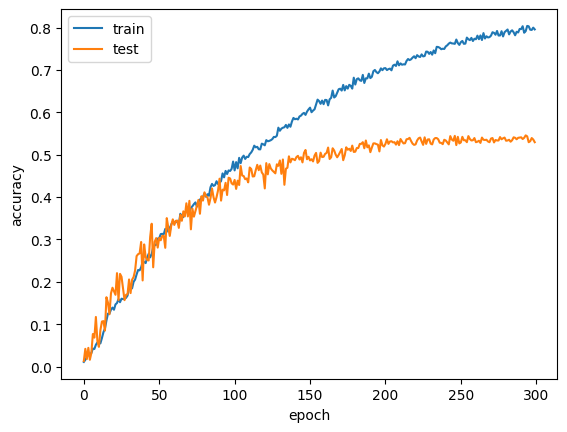

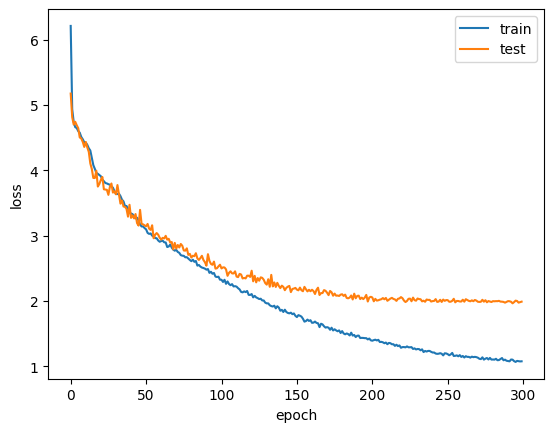

In [12]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [13]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCaltech101_ReLU_ReLU1_ReLUmaxpool_EST_FC2_corrected_trilinear_mixed_L1_L2_Vol2.csv')

In [14]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.011051,0.013211,6.208916,5.173425
1,0.016073,0.041930,4.934537,4.812321
2,0.022675,0.017806,4.737786,4.698470
3,0.028990,0.044227,4.658889,4.741715
4,0.030138,0.016083,4.646135,4.688931


In [15]:
df.tail()

,train_acc,test_acc,train_loss,test_loss
295,0.803100,0.529581,1.065672,2.003562
296,0.795063,0.531878,1.081216,1.998114
297,0.794489,0.539345,1.077523,1.973405
298,0.799943,0.535899,1.073233,1.981479
299,0.795781,0.529581,1.075135,1.988159


In [16]:
print(df["test_acc"].max())

0.5456634118322803


In [17]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.011051  0.013211    6.208916   5.173425
1     0.016073  0.041930    4.934537   4.812321
2     0.022675  0.017806    4.737786   4.698470
3     0.028990  0.044227    4.658889   4.741715
4     0.030138  0.016083    4.646135   4.688931
5     0.031716  0.032165    4.598870   4.643278
6     0.042480  0.076967    4.574740   4.501350
7     0.041619  0.068352    4.509693   4.486771
8     0.051521  0.117174    4.474021   4.433734
9     0.057118  0.060310    4.428391   4.356579
10    0.053817  0.046525    4.423616   4.433010
11    0.054966  0.086157    4.388895   4.349171
12    0.067308  0.106261    4.335977   4.281346
13    0.081085  0.107410    4.302189   4.104145
14    0.089552  0.085009    4.193835   4.020316
15    0.108783  0.163699    4.078257   3.881645
16    0.125000  0.151063    4.021446   3.880764
17    0.125287  0.123492    3.959753   3.991736
18    0.134328  0.172889    3.944924   3.750040
19    0.139208  0.186100    3.926729   3